In [35]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b
import math

In [36]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [37]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [38]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
#     ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
#     ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
#     ec13 = alpha13**(-1/2)*(1-alpha13)

    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    Delta = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    
    # coefficients for S1'
    c_e12 = -(mu1+mu3)**2*mu1*a
    c_e23 = (mu1+mu3)**2*mu3*b
    c1, c2, c3 = -c_e12, (c_e12-c_e23), c_e23
    
    # coefficients for S2'
    c_e13 = (mu3-mu1*mu2)*b + (mu1-mu2*mu3)*a
#     c_eminus = -16*mu2*Delta
    c_eminus = 0
    d1, d2, d3 = -c_e13+c_eminus*mu1, -c_eminus*(mu1+mu3), c_e13+c_eminus*mu3
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    S1ax, S1ay, S2ax, S2ay, S3ax, S3ay = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)    
#         Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
#         Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
        
        Gx[i] = [np.sqrt(p.m)*p.e*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(p.m)*p.e*np.sin(-p.pomega) for p in ps[1:]]
        
        S1ax[i] = c1*ps[1].e*np.cos(-ps[1].pomega) + c2*ps[2].e*np.cos(-ps[2].pomega) + c3*ps[3].e*np.cos(-ps[3].pomega)
        S1ay[i] = c1*ps[1].e*np.sin(-ps[1].pomega) + c2*ps[2].e*np.sin(-ps[2].pomega) + c3*ps[3].e*np.sin(-ps[3].pomega)
        S2ax[i] = d1*ps[1].e*np.cos(-ps[1].pomega) + d2*ps[2].e*np.cos(-ps[2].pomega) + d3*ps[3].e*np.cos(-ps[3].pomega)
        S2ay[i] = d1*ps[1].e*np.sin(-ps[1].pomega) + d2*ps[2].e*np.sin(-ps[2].pomega) + d3*ps[3].e*np.sin(-ps[3].pomega)
        S3ax[i] = mu1*ps[1].e*np.cos(-ps[1].pomega) + mu2*ps[2].e*np.cos(-ps[2].pomega) + mu3*ps[3].e*np.cos(-ps[3].pomega)
        S3ay[i] = mu1*ps[1].e*np.sin(-ps[1].pomega) + mu2*ps[2].e*np.sin(-ps[2].pomega) + mu3*ps[3].e*np.sin(-ps[3].pomega)
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T
       
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a = np.sqrt(S1ax**2 + S1ay**2)
    S2a = np.sqrt(S2ax**2 + S2ay**2)
    S3a = np.sqrt(S3ax**2 + S3ay**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

In [75]:
alpha = solveAlpha(0.8, 0.04)
mass = (1-1/3)/2*1e-7,1/3*1e-7,(1-1/3)/2*1e-7
ecc = 0.005, 0.005, 0.005
pomega = np.pi/3, 0, -2*np.pi/3

e1x, e1y = ecc[0]*np.cos(pomega[0]), ecc[0]*np.sin(pomega[0])
e2x, e2y = ecc[1]*np.cos(pomega[1]), ecc[1]*np.sin(pomega[1])
e3x, e3y = ecc[2]*np.cos(pomega[2]), ecc[2]*np.sin(pomega[2])

print(f"e13 = {np.sqrt((e1x-e3x)**2 + (e1y-e3y)**2)}")
print(f"eminus = {np.sqrt((e1x-2*e2x+e3x)**2 + (e1y-2*e2y+e3y)**2)}")

# sim = make_sim(alpha, mass, ecc, pomega)
# times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

e13 = 0.008660254037844387
eminus = 0.014999999999999998


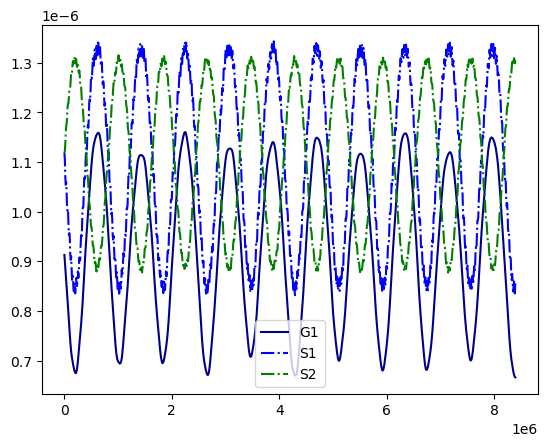

In [77]:
fig, ax = plt.subplots()
ax.plot(times, G1, color='darkblue', label='G1')
# ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
# ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1, color='blue', linestyle='-.', label='S1')
ax.plot(times, S2, color='green', linestyle='-.', label='S2')
# ax.plot(times, S3/S3[0], color='orange', linestyle='-.', label='S3')
ax.legend()

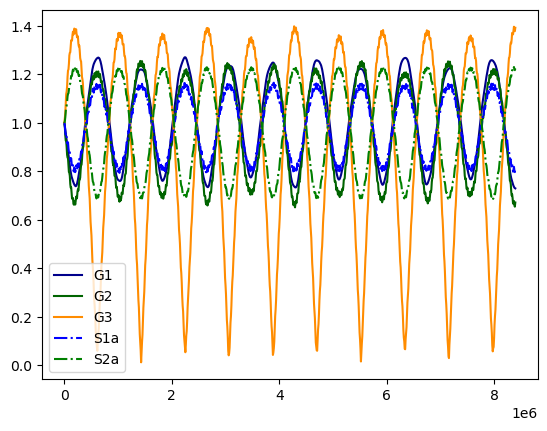

In [73]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], color='darkblue', label='G1')
ax.plot(times, G2/G2[0], color='darkgreen', label='G2')
ax.plot(times, G3/G3[0], color='darkorange', label='G3')
ax.plot(times, S1a/S1a[0], color='blue', linestyle='-.', label='S1a')
ax.plot(times, S2a/S2a[0], color='green', linestyle='-.', label='S2a')
# ax.plot(times, S3a, color='orange', linestyle='-.', label='S3a')
ax.legend()

In [ ]:
amp(S2a)/amp(G2)

In [ ]:
modeDistance(sim)

# Mode Approximation

In [39]:
def calcMode(sim):
    ps = sim.particles
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
#     ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
#     ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
#     ec13 = alpha13**(-1/2)*(1-alpha13)
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    Delta = (ec12 - ec23)/ec13
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    
    c_e12 = -(mu1+mu3)**2*mu1*a
    c_e23 = (mu1+mu3)**2*mu3*b
    c1, c2, c3 = -c_e12, (c_e12-c_e23), c_e23
    
    c_e13 = (mu3-mu1*mu2)*b + (mu1-mu2*mu3)*a
#     c_eminus = -16*mu2*Delta
    c_eminus = 0
    d1, d2, d3 = -c_e13+c_eminus*mu1, -c_eminus*(mu1+mu3), c_e13+c_eminus*mu3
    
    return 1/np.sqrt(c1**2+c2**2+c3**2) * np.array([c1, c2, c3]), 1/np.sqrt(d1**2+d2**2+d3**2) * np.array([d1, d2, d3])

In [40]:
def calcPsi(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
#     ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
#     ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
#     ec13 = alpha13**(-1/2)*(1-alpha13)
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13

    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    psi_theo = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    
    Delta = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    
    psi_approx = -16*sqrt(mu1*mu2*mu3)*Delta/(a*(mu1+mu3)+16*mu3*Delta-mu2*((mu1+mu3)*b-16*mu3*Delta))
    return Delta, psi_theo, psi_approx

In [41]:
from sympy import *
init_printing()
M1, M2, M3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)

G = Matrix([sqrt(M1)*e1, sqrt(M2)*e2, sqrt(M3)*e3])

In [42]:
# normalized coefficients in front of e1, e2, and e3 (i.e., unit vector in e1, e2 and e3 bases)
def convert(x):
    coeff1 = x.split("*e_1")[0]
    coeff1 = float(coeff1.replace(" ", ""))
    coeff2 = (x.split("*e_1")[1]).split("*e_2")[0]
    coeff2 = float(coeff2.replace(" ", ""))
    coeff3 = ((x.split("*e_1")[1]).split("*e_2")[1]).split("*e_3")[0]
    coeff3 = float(coeff3.replace(" ", ""))
    
    return 1/np.sqrt(coeff1**2+coeff2**2+coeff3**2) * np.array([coeff1, coeff2, coeff3])

In [43]:
def modeDistance(sim):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M)
    exp_theo1 = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    vec_theo1 = convert(str(exp_theo1))
    exp_theo2 = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[1]
    vec_theo2 = convert(str(exp_theo2))
    
    vec_approx1, vec_approx2 = calcMode(sim)
    
    dist1 = min([np.linalg.norm(vec_theo1-vec_approx1),np.linalg.norm(vec_theo1+vec_approx1)])
    dist2 = min([np.linalg.norm(vec_theo2-vec_approx2),np.linalg.norm(vec_theo2+vec_approx2)])
    
    return dist1, dist2

In [44]:
def amp(x):
    return (max(x)-min(x))/(2*np.mean(x))

In [45]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [81]:
def solveAlpha(a13, Delta):
#     dfunc = lambda a1 : (a1**(-1/4)*(a13/a1)**(5/8)*(1-a1) - a1**(1/8)*(a13/a1)**(-1/2)*(1-(a13/a1))) / (a13**(-1/2)*(1-a13)) - Delta
    dfunc = lambda a1 : ((1-a1) - (1-(a13/a1))) / ((1-a13)) - Delta
    a1_initial_guess = 0.8
    a1_val = fsolve(dfunc, a1_initial_guess)
    return a1_val[0], a13/a1_val[0]

In [ ]:
a13 = np.linspace(0.55, 0.8, 50)
alpha_param = [[solveAlpha(x,0)[0], solveAlpha(x,0)[1]] for x in a13]
ecc = 0.005, 0.005, 0.005
pomega = 0, 2*np.pi/3, -2*np.pi/3

data = np.zeros((len(alpha_param),13))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    mass = 1e-7, 1e-15, 1e-7
    sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
    dist1, dist2 = modeDistance(sim)
    delta, psi_theo, psi_approx = calcPsi(sim)

    times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)
    amp_G1, amp_G2, amp_S1, amp_S2, amp_S1a, amp_S2a = amp(G1), amp(G2), amp(S1), amp(S2), amp(S1a), amp(S2a)

    data[i][:] = alpha1*alpha2, alpha1, alpha2, dist1, dist2, amp_G1, amp_G2, amp_S1, amp_S2, amp_S1a, amp_S2a, psi_theo, psi_approx

In [ ]:
pd.set_option('display.max_rows', 10)
df = pd.DataFrame(data, columns=['alpha13','alpha12','alpha23','dist1','dist2','G1','G2','S1','S2','S1a','S2a','psi_theo','psi_approx'], index=None)
df.to_csv("varyAlpha13.csv",index=False)

## Vary $\Delta$ and $\tilde{m}_2$

In [ ]:
mass_param = np.array([1/10, 1/5, 1/3])
a13 = 0.8
delta = np.linspace(-0.4,0.4,13)
alpha_param = [[solveAlpha(a13,d)[0], solveAlpha(a13,d)[1]] for d in delta]
ecc = 0.005, 0.005, 0.005
pomega = 0, 2*np.pi/3, -2*np.pi/3

data = np.zeros((len(mass_param)*len(alpha_param),15))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, m2 in enumerate(mass_param):
        mass = (1-m2)/2*3e-8, m2*3e-8, (1-m2)/2*3e-8
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        dist1, dist2 = modeDistance(sim)
        delta, psi_theo, psi_approx = calcPsi(sim)
        
        times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)
        amp_G1, amp_G2, amp_G3, amp_S1, amp_S2, amp_S1a, amp_S2a = amp(G1), amp(G2), amp(G3), amp(S1), amp(S2), amp(S1a), amp(S2a)
        
        data[i*len(mass_param)+j][:] = m2, delta, alpha1, alpha2, dist1, dist2, amp_G1, amp_G2, amp_G3, amp_S1, amp_S2, amp_S1a, amp_S2a, psi_theo, psi_approx

In [ ]:
pd.set_option('display.max_rows', 13)
df = pd.DataFrame(data, columns=['m2','Delta','alpha12','alpha23','dist1','dist2','G1','G2','G3','S1','S2','S1a','S2a','psi_theo','psi_approx'], index=None)
df

In [ ]:
df.to_csv("varyDelta.csv",index=False)

In [90]:
def fitDelta(d):
    x = [d.iloc[i]['Delta'] for i in range(len(d)) if d.iloc[i]['S1']/d.iloc[i]['G2'] < 0.05]
    y1 = [(d.iloc[i]['S1a']-d.iloc[i]['S1']) for i in range(len(d)) if d.iloc[i]['S1']/d.iloc[i]['G2'] < 0.05]
    y2 = [(d.iloc[i]['S2a']-d.iloc[i]['S2']) for i in range(len(d)) if d.iloc[i]['S1']/d.iloc[i]['G2'] < 0.05]
#     for i in range(len(y)):
#         if y[i] < 0:
#             y[i] = 0
    return x, y1

In [51]:
def deltaBound(m2,psi):
    deltaLimit = lambda x : np.sqrt(m2)*((x-1)**3*(x+3)-(x+1)**3*(x-3))/((1-m2)*((x-1)**3*(x+3)+(x+1)**3*(x-3))) - psi
    d_initial_guess = 0.5
    d_bound = fsolve(deltaLimit, d_initial_guess)
    return d_bound

In [ ]:
df

In [ ]:
df = pd.read_csv('testing_test_particle.csv')
# d = df[df['m2'] == 1/3]
x, y1, y2 = fitDelta(df)
f, ax1 = plt.subplots()
ax1.scatter(x,y1,marker='.',color=c1,label='S1')
ax1.scatter(x,y2,marker='.',color=c2,label='S2')
ax1.legend()

In [86]:
# df = pd.read_csv('general_case.csv')
df[df['m2'] == 1/3]

,m2,Delta,alpha12,alpha23,dist1,dist2,G1,G2,G3,S1,S2,S1a,S2a,psi_theo,psi_approx
2,0.333333,-4.000000e-01,0.935321,0.855321,0.053880,0.489079,0.639201,0.581760,0.077752,0.007015,0.008292,0.049609,0.505395,0.492559,7.043720e-01
5,0.333333,-3.333333e-01,0.928381,0.861715,0.074770,0.470215,0.404818,0.185575,0.715890,0.650804,0.638974,0.578591,0.139474,0.473242,6.319645e-01
8,0.333333,-2.666667e-01,0.921491,0.868158,0.098950,0.441951,0.671671,0.530328,0.118965,0.008576,0.010886,0.092749,0.452889,0.444283,5.399566e-01
11,0.333333,-2.000000e-01,0.914651,0.874651,0.123081,0.399461,0.677141,0.523808,0.104778,0.048263,0.060639,0.172207,0.465053,0.400836,4.278782e-01
14,0.333333,-1.333333e-01,0.907860,0.881193,0.140001,0.335486,0.766627,0.407681,0.230335,0.012618,0.013604,0.129744,0.345275,0.335679,2.973780e-01
17,0.333333,-6.666666e-02,0.901119,0.887785,0.138355,0.240868,0.762343,0.305357,0.324152,0.012028,0.018519,0.130078,0.254093,0.239763,1.526046e-01
20,0.333333,-6.106226e-15,0.894427,0.894427,0.108184,0.111357,0.603866,0.154464,0.432528,0.016908,0.015758,0.094129,0.122291,0.108226,1.410173e-14
23,0.333333,6.666666e-02,0.887785,0.901119,0.055872,0.052076,0.447676,0.060515,0.599139,0.023357,0.009967,0.034927,0.036453,-0.045504,-1.526046e-01
26,0.333333,1.333333e-01,0.881193,0.907860,0.008230,0.190241,0.361773,0.204291,0.770819,0.015693,0.014507,0.009185,0.176678,-0.188866,-2.973780e-01
29,0.333333,2.000000e-01,0.874651,0.914651,0.022012,0.298849,0.138350,0.426840,0.657203,0.130226,0.108227,0.151495,0.417652,-0.298944,-4.278782e-01


Text(0, 0.5, "$\\frac{\\bar{\\mathtt{A}}({S}_{1,app}') - \\bar{\\mathtt{A}}({S}_{1,theo}')}{\\bar{\\mathtt{A}}(G_2)}$")

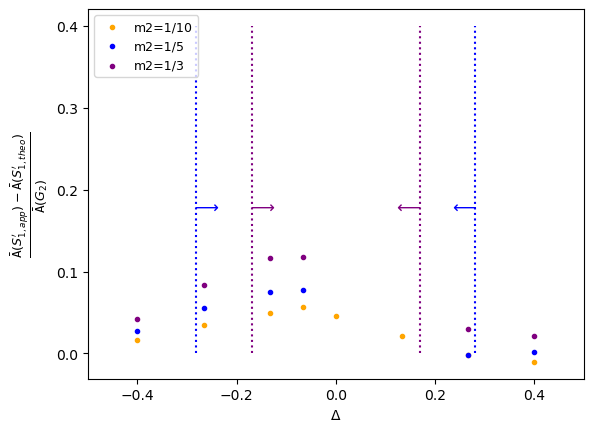

In [92]:
df = pd.read_csv('varyDelta.csv')
d1 = df[df['m2'] == 1/10]
d2 = df[df['m2'].between(0.19,0.21)]
d3 = df[df['m2'] == 1/3]
x1,y1 = fitDelta(d1)
x2,y2 = fitDelta(d2)
x3,y3 = fitDelta(d3)

f, ax1 = plt.subplots()
c1, c2, c3 = 'orange', 'blue', 'purple'
ax1.scatter(x1,y1,marker='.',color=c1,label='m2=1/10')
ax1.scatter(x2,y2,marker='.',color=c2,label='m2=1/5')
ax1.scatter(x3,y3,marker='.',color=c3,label='m2=1/3') 
ymin, ymax = 0, 0.4
percentage = 0.3
b1, b2, b3 = percentage/(16/3*1/10), -percentage/(16/3*1/5), -percentage/(16/3*1/3)
# ax1.vlines([b1,-b1],ymin,ymax,linestyle=':',color=c1)
ax1.vlines([b2,-b2],ymin,ymax,linestyle=':',color=c2)
ax1.vlines([b3,-b3],ymin,ymax,linestyle=':',color=c3)

text_xpos = 0.18
# ax1.text(b1-0.01,text_xpos,r'$\longrightarrow$', color=c1, fontsize=12, horizontalalignment='left', verticalalignment='center')
# ax1.text(-b1+0.003,text_xpos,r'$\longleftarrow$', color=c1, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b2-0.01,text_xpos,r'$\longrightarrow$', color=c2, fontsize=12, horizontalalignment='left', verticalalignment='center')
ax1.text(-b2+0.003,text_xpos,r'$\longleftarrow$', color=c2, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b3-0.01,text_xpos,r'$\longrightarrow$', color=c3, fontsize=12, horizontalalignment='left', verticalalignment='center')
ax1.text(-b3+0.003,text_xpos,r'$\longleftarrow$', color=c3, fontsize=12, horizontalalignment='right', verticalalignment='center')

ax1.legend(loc='upper left',fontsize=9)
ax1.set_xlim(-0.5,0.5)
# ax1.set_ylim(-0.02,0.25)
ax1.set_xlabel('$\Delta$')
ax1.set_ylabel(r"$\frac{\bar{\mathtt{A}}({S}_{1,app}') - \bar{\mathtt{A}}({S}_{1,theo}')}{\bar{\mathtt{A}}(G_2)}$",fontsize=13)

In [ ]:
def fitM2(d):
    x = [d.iloc[i]['m2'] for i in range(len(d)) if d.iloc[i]['S1'] < 0.05]
    y = [(d.iloc[i]['S1a']-d.iloc[i]['S1']) / d.iloc[i]['G2'] for i in range(len(d)) if d.iloc[i]['S1'] < 0.05]
    return x,y

In [ ]:
def m2Bound(delta,psi):
    m2Limit = lambda m2 : np.sqrt(m2)*((delta-1)**3*(delta+3)-(delta+1)**3*(delta-3))/((1-m2)*((delta-1)**3*(delta+3)+(delta+1)**3*(delta-3))) - psi
    m2_initial_guess = 1/4
    m2_bound = fsolve(m2Limit, m2_initial_guess)
    return m2_bound

In [ ]:
df = pd.read_csv('general_case.csv')
d1 = df[df['Delta'].between(-0.01,0.01)]
d2 = df[df['Delta'].between(0.06,0.07)]
d3 = df[df['Delta'].between(0.13,0.14)]
d4 = df[df['Delta'].between(0.19,0.21)]
d5 = df[df['Delta'].between(0.26,0.27)]
d6 = df[df['Delta'].between(0.33,0.34)]
d7 = df[df['Delta'].between(0.39,0.41)]

f,ax1 = plt.subplots()
x1,y1 = fitM2(d1)
x2,y2 = fitM2(d2)
x3,y3 = fitM2(d3)
x4,y4 = fitM2(d4)
x5,y5 = fitM2(d5)
x6,y6 = fitM2(d6)
x7,y7 = fitM2(d7)

ax1.scatter(x1,y1,marker='.',label='$\Delta=0$')
ax1.scatter(x2,y2,marker='.',label='$\Delta=0.07$')
ax1.scatter(x3,y3,marker='.',label='$\Delta=0.13$')
ax1.scatter(x4,y4,marker='.',label='$\Delta=0.20$')
ax1.scatter(x5,y5,marker='.',label='$\Delta=0.27$')
ax1.scatter(x6,y6,marker='.',label='$\Delta=0.33$')
ax1.scatter(x7,y7,marker='.',label='$\Delta=0.40$')

ax1.legend(ncols=2, fontsize=9)
ax1.set_ylim(0,0.25)
ax1.set_xlabel(r"$\tilde{m}_2$")
ax1.set_ylabel(r"$\frac{\bar{\mathtt{A}}({S}_{1,app}') - \bar{\mathtt{A}}({S}_{1,theo}')}{\bar{\mathtt{A}}(G_2)}$",fontsize=13)